## Imports

In [ ]:
import pandas as pd
import numpy as np
import joblib
import requests
import re
from tqdm import tqdm
from itertools import product
from sklearn.metrics import root_mean_squared_error, accuracy_score, precision_score, recall_score, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, BaggingRegressor, VotingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Forecast

### Data preparation
- Use the dataset from Epicurious collected by HugoDarwood.
- Filter the columns: the less non-ingredient columns in your
dataset the better. You will predict the rating or rating category using only the ingredients and nothing else.

In [ ]:
data = pd.read_csv('../data/epi_r.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB


In [ ]:
data = data[[col for col in data.columns if all(c not in col for c in ['/', '_', '-', ' '])]]
data = data[[col for col in data.columns if not col.startswith('#')]]

stoplist = ['calories', 'protein', 'fat', 'sodium', 'atlanta', 'alcoholic', 'anniversary', 'wheat/gluten-free', 'wedding', 'vegetarian', 'vegan', 'non-alcoholic', 'no-cook', 'london', 'louisville', 'halloween', 'graduation', 'gourmet', 'friendsgiving', 'entertaining']
states = pd.read_csv('../data/us_states.csv')
states_list = states.values.flatten()
states_list = [str(val).lower() for val in states_list]
stoplist += states_list

countries = pd.read_csv('../data/countries.csv')
countries_list = countries.values.flatten()
countries_list = [str(val).lower() for val in countries_list]
stoplist += countries_list

data = data[[col for col in data.columns if col not in stoplist]]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 408 entries, title to turkey
dtypes: float64(407), object(1)
memory usage: 62.4+ MB


### Regression

- Try different algorithms and their hyperparameters for rating prediction. Choose the best on cross-validation and find the score (RMSE) on the test subsample.

In [ ]:
class RegressionModelSelection():
    def __init__(self, grids, model_names):
        self.grids = grids
        self.model_names = model_names
        self.models_info = []

    def choose(self, X_train, y_train, X_valid, y_valid):
        best_score = float('inf')
        best_model_name = None

        for i, grid in enumerate(self.grids):
            model_name = self.model_names[i]
            print(f"Estimator: {model_name}")

            grid.fit(X_train, y_train)
            best_params = grid.best_params_
            print(f"Best params: {best_params}")
            best_estimator = grid.best_estimator_

            mean_cv_rmse = -grid.best_score_
            print(f"Mean CV RMSE: {mean_cv_rmse:.3f}")

            valid_preds = best_estimator.predict(X_valid)
            valid_rmse = root_mean_squared_error(y_valid, valid_preds)
            print(f"Validation set RMSE for best params: {valid_rmse:.3f}\n")

            if valid_rmse < best_score:
                best_score = valid_rmse
                best_model_name = model_name

            self.models_info.append({
                "model": model_name,
                "params": best_params,
                "cv_rmse": mean_cv_rmse,
                "valid_rmse": valid_rmse,
                "estimator": best_estimator
            })

        return best_model_name

    def best_results(self):
        return pd.DataFrame(self.models_info)


In [ ]:
data_y = data['rating']
data_X = data.copy()
data_X = data_X.drop(columns=['rating', 'title'])

X_train_full, X_test, y_train_full, y_test = train_test_split(
    data_X, data_y,
    test_size=0.2,
    random_state=21
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    random_state=21
)

In [ ]:
linreg = LinearRegression()
linreg_params = [{
    'fit_intercept': [True, False],
    'positive': [True, False]
}]
gs_linreg = GridSearchCV(estimator=linreg, param_grid=linreg_params, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)

In [ ]:
tree = DecisionTreeRegressor(random_state=21)
tree_params = [{
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 5, 7],
    'max_features': ['sqrt', 'log2', None]
}]
gs_tree = GridSearchCV(estimator=tree, param_grid=tree_params, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)

In [ ]:
forest = RandomForestRegressor(random_state=21)
forest_params = [{
    'n_estimators': [100, 50],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}]
gs_forest = GridSearchCV(estimator=forest, param_grid=forest_params, scoring='neg_root_mean_squared_error', cv=2, n_jobs=2)

In [ ]:
grids = [gs_linreg, gs_tree, gs_forest]
grid_names = ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor']

selector = RegressionModelSelection(grids, grid_names)
best_name = selector.choose(X_train, y_train, X_valid, y_valid)

Estimator: Linear Regression
Best params: {'fit_intercept': True, 'positive': False}
Mean CV RMSE: 1.279
Validation set RMSE for best params: 1.244

Estimator: Decision Tree Regressor
Best params: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Mean CV RMSE: 1.287
Validation set RMSE for best params: 1.259

Estimator: Random Forest Regressor
Best params: {'max_depth': 15, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Mean CV RMSE: 1.270
Validation set RMSE for best params: 1.228



In [ ]:
### RMSE ON THE TEST SUBSAMPLE
best_grid = selector.grids[grid_names.index(best_name)]
best_model = best_grid.best_estimator_

test_preds = best_model.predict(X_test)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f"{best_name}, test RMSE: {test_rmse:.3f}")

Random Forest Regressor, test RMSE: 1.241


- Try different ensembles and their hyperparameters. Choose the best on cross-validation and find the score on the test subsample.

In [ ]:
hgb = HistGradientBoostingRegressor(random_state=21, early_stopping=True)

hgb_params = [{
    'learning_rate': [0.05, 0.1],
    'max_iter': [200, 100],
    'max_depth': [5, 10, None],
    'l2_regularization': [0.0, 1.0, 2.0],
    'max_leaf_nodes': [10, 20, 30]
}]

gs_hgb = GridSearchCV(
    estimator=hgb,
    param_grid=hgb_params,
    scoring='neg_root_mean_squared_error',
    cv=2,
    n_jobs=-1
)

In [ ]:
bagging = BaggingRegressor(DecisionTreeRegressor(), random_state=21)

bagging_params = [{
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}]

gs_bagging = GridSearchCV(
    estimator=bagging,
    param_grid=bagging_params,
    scoring='neg_root_mean_squared_error',
    cv=2,
    n_jobs=-1
)

In [ ]:
kneighbors = KNeighborsRegressor()

voting = VotingRegressor([('tree', tree), ('forest', forest), ('kneighbors', kneighbors)])

voting_params = {
    'weights': [[1, 1, 1],
                [2, 1, 1],
                [1, 2, 1],
                [1, 1, 2]]
}

gs_voting = GridSearchCV(
    estimator=voting,
    param_grid=voting_params,
    scoring='neg_root_mean_squared_error',
    cv=2,
    n_jobs=-1
)

In [ ]:
grids = [gs_hgb, gs_bagging, gs_voting]
model_names = ['Hist Gradient Boosting Regressor', 'Bagging Regressor', 'Voting Regressor']

selector = RegressionModelSelection(grids, model_names)
best_name = selector.choose(X_train, y_train, X_valid, y_valid)

Estimator: Hist Gradient Boosting Regressor
Best params: {'l2_regularization': 2.0, 'learning_rate': 0.1, 'max_depth': None, 'max_iter': 200, 'max_leaf_nodes': 30}
Mean CV RMSE: 1.268
Validation set RMSE for best params: 1.215

Estimator: Bagging Regressor
Best params: {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 100}
Mean CV RMSE: 1.244
Validation set RMSE for best params: 1.202

Estimator: Voting Regressor
Best params: {'weights': [1, 2, 1]}
Mean CV RMSE: 1.318
Validation set RMSE for best params: 1.276



In [ ]:
### RMSE ON THE TEST SUBSAMPLE
best_grid = selector.grids[model_names.index(best_name)]
best_model = best_grid.best_estimator_

test_preds = best_model.predict(X_test)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f"{best_name}, test RMSE: {test_rmse:.3f}")

Bagging Regressor, test RMSE: 1.201


- Calculate the RMSE for a naive regressor that predicts the average rating.

In [ ]:
avg_rating = y_train.mean()
naive_preds = np.full_like(y_test, avg_rating)
naive_rmse = root_mean_squared_error(y_test, naive_preds)
print(f"Naive regressor (average rating), test RMSE: {naive_rmse:.3f}")

Naive regressor (average rating), test RMSE: 1.307


### Classification

- Binarize the target column by rounding the ratings to the closest integer. This will be your classes.

In [ ]:
y_train_int = y_train.round().astype(int)
y_test_int = y_test.round().astype(int)
y_valid_int = y_valid.round().astype(int)
y_train_full_int = y_train_full.round().astype(int)

- Try different algorithms and their hyperparameters for class prediction. Choose the best on cross-validation and find the score (accuracy) on the test subsample.

In [ ]:
class ClassificationModelSelection():
    def __init__(self, grids, model_names):
        self.grids = grids
        self.model_names = model_names
        self.models_info = []

    def choose(self, X_train, y_train_int, X_valid, y_valid_int):
        best_score = 0
        best_model_name = None

        for i, grid in enumerate(self.grids):
            model_name = self.model_names[i]
            print(f"Estimator: {model_name}")

            grid.fit(X_train, y_train_int)
            best_params = grid.best_params_
            print(f"Best params: {best_params}")
            best_estimator = grid.best_estimator_

            mean_cv_acc = grid.best_score_
            print(f"Mean CV accuracy: {mean_cv_acc:.3f}")

            valid_preds = best_estimator.predict(X_valid)
            valid_acc = accuracy_score(y_valid_int, valid_preds)
            print(f"Validation set accuracy for best params: {valid_acc:.3f}\n")

            if valid_acc > best_score:
                best_score = valid_acc
                best_model_name = model_name

            self.models_info.append({
                "model": model_name,
                "params": best_params,
                "cv_acc": mean_cv_acc,
                "valid_acc": valid_acc,
                "estimator": best_estimator
            })

        return best_model_name

    def best_results(self):
        return pd.DataFrame(self.models_info)


In [ ]:
svm = SVC(random_state=21)
svm_params = [{'kernel':['linear'],
               'C':[0.1, 1, 5],
               'class_weight':('balanced', None)}]
gs_svm = GridSearchCV(estimator=svm, param_grid=svm_params, scoring='accuracy', cv=2, n_jobs=2)

tree = DecisionTreeClassifier(random_state=21)
tree_params = [{'max_depth': [10, 15, None],
                'class_weight': ['balanced', None],
                'criterion': ['entropy', 'gini']}]
gs_tree = GridSearchCV(estimator=tree, param_grid=tree_params, scoring='accuracy', cv=2, n_jobs=2)

rf = RandomForestClassifier(random_state=21)
rf_params = [{'n_estimators': [100, 200],
              'max_depth': [10, None],
              'class_weight': ['balanced', None],
              'criterion': ['entropy', 'gini']}]
gs_rf = GridSearchCV(estimator=rf, param_grid=rf_params, scoring='accuracy', cv=2, n_jobs=1)

grids = [gs_svm, gs_tree, gs_rf]
model_names = ["SVM", "Decision Tree", "Random Forest"]

In [ ]:
selector = ClassificationModelSelection(grids, model_names)
best_name = selector.choose(X_train, y_train_int, X_valid, y_valid_int)

Estimator: SVM
Best params: {'C': 1, 'class_weight': None, 'kernel': 'linear'}
Mean CV accuracy: 0.668
Validation set accuracy for best params: 0.674

Estimator: Decision Tree
Best params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 10}
Mean CV accuracy: 0.659
Validation set accuracy for best params: 0.672

Estimator: Random Forest
Best params: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 200}
Mean CV accuracy: 0.683
Validation set accuracy for best params: 0.701



In [ ]:
### ACCURACY ON THE TEST SUBSAMPLE
best_grid = selector.grids[model_names.index(best_name)]
best_model = best_grid.best_estimator_

test_preds = best_model.predict(X_test)
test_acc = accuracy_score(y_test_int, test_preds)
print(f"{best_name}, test accuracy: {test_acc:.3f}")

Random Forest, test accuracy: 0.703


- Compare the metrics using accuracy. Calculate the accuracy of a naive classificator that predicts the most common class.

In [ ]:
most_common_rating = y_train_int.mode()[0]
naive_preds = pd.Series(most_common_rating, index=y_test_int.index)
naive_acc = accuracy_score(y_test_int, naive_preds)
print(f"Naive classifier (most common class), test accuracy: {naive_acc:.3f}")

Naive classifier (most common class), test accuracy: 0.671


- Binarize the target column again by converting the integers to classes ‘bad’ (0, 1), ‘so-so’ (2, 3), ‘great’ (4, 5).

In [ ]:
y_train_class = y_train_int.map(lambda x: 'bad' if x in (0, 1) else 'so-so' if x in (2, 3) else 'great')
y_test_class = y_test_int.map(lambda x: 'bad' if x in (0, 1) else 'so-so' if x in (2, 3) else 'great')
y_valid_class = y_valid_int.map(lambda x: 'bad' if x in (0, 1) else 'so-so' if x in (2, 3) else 'great')
y_train_full_class = y_train_full_int.map(lambda x: 'bad' if x in (0, 1) else 'so-so' if x in (2, 3) else 'great')

- Try different algorithms and their hyperparameters for class prediction. Choose the best on cross-validation and find the score on the test subsample.

In [ ]:
svm = SVC(random_state=21)
svm_params = [{'kernel':['linear'],
               'C':[0.1, 1, 5],
               'class_weight':('balanced', None)}]
gs_svm = GridSearchCV(estimator=svm, param_grid=svm_params, scoring='accuracy', cv=2, n_jobs=2)

tree = DecisionTreeClassifier(random_state=21)
tree_params = [{'max_depth': [10, 15, None],
                'class_weight': ['balanced', None],
                'criterion': ['entropy', 'gini']}]
gs_tree = GridSearchCV(estimator=tree, param_grid=tree_params, scoring='accuracy', cv=2, n_jobs=2)

rf = RandomForestClassifier(random_state=21)
rf_params = [{'n_estimators': [100, 200],
              'max_depth': [10, None],
              'class_weight': ['balanced', None],
              'criterion': ['entropy', 'gini']}]
gs_rf = GridSearchCV(estimator=rf, param_grid=rf_params, scoring='accuracy', cv=2, n_jobs=1)

grids = [gs_svm, gs_tree, gs_rf]
model_names = ["SVM", "Decision Tree", "Random Forest"]

selector = ClassificationModelSelection(grids, model_names)
best_name = selector.choose(X_train, y_train_class, X_valid, y_valid_class)

Estimator: SVM
Best params: {'C': 1, 'class_weight': None, 'kernel': 'linear'}
Mean CV accuracy: 0.798
Validation set accuracy for best params: 0.805

Estimator: Decision Tree
Best params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 10}
Mean CV accuracy: 0.796
Validation set accuracy for best params: 0.802

Estimator: Random Forest
Best params: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}
Mean CV accuracy: 0.811
Validation set accuracy for best params: 0.820



In [ ]:
### ACCURACY ON THE TEST SUBSAMPLE
best_grid = selector.grids[model_names.index(best_name)]
best_model = best_grid.best_estimator_

test_preds = best_model.predict(X_test)
test_acc = accuracy_score(y_test_class, test_preds)
print(f"{best_name}, test accuracy: {test_acc:.3f}")

Random Forest, test accuracy: 0.819


- Compare the metrics using accuracy. Calculate the accuracy of a naive classificator that predicts the most common class.

In [ ]:
most_common_class = y_train_class.mode()[0]
naive_preds = pd.Series(most_common_class, index=y_test_class.index)
naive_acc = accuracy_score(y_test_class, naive_preds)
print(f"Naive classifier (most common class), test accuracy: {naive_acc:.3f}")

Naive classifier (most common class), test accuracy: 0.798


- What is worse: to predict a bad rating which is good in real life, or to predict a good rating which is bad in real life? Replace accuracy with the appropriate metric.

Предсказать плохой рейтинг, когда на самом деле он хороший, - ложноотрицательная ошибка (FP). Предсказать хороший рейтинг, когда на самом деле он плохой, - ложноположительная ошибка (FN).

В первом случае рекомендуется использовать метрику recall, во втором - precision.

In [ ]:
class ClassificationModelSelection():
    def __init__(self, grids, model_names):
        self.grids = grids
        self.model_names = model_names
        self.models_info = []

    def choose(self, X_train, y_train_class, X_valid, y_valid_class):
        best_score = 0
        best_model_name = None

        for i, grid in enumerate(self.grids):
            model_name = self.model_names[i]
            print(f"Estimator: {model_name}")

            grid.fit(X_train, y_train_class)
            best_params = grid.best_params_
            print(f"Best params: {best_params}")
            best_estimator = grid.best_estimator_

            mean_cv_prec = grid.best_score_
            print(f"Mean CV precision: {mean_cv_prec:.3f}")

            valid_preds = best_estimator.predict(X_valid)
            valid_prec = precision_score(y_valid_class, valid_preds, average='weighted')
            print(f"Validation set precision for best params: {valid_prec:.3f}\n")

            if valid_prec > best_score:
                best_score = valid_prec
                best_model_name = model_name

            self.models_info.append({
                "model": model_name,
                "params": best_params,
                "cv_prec": mean_cv_prec,
                "valid_prec": valid_prec,
                "estimator": best_estimator
            })

        return best_model_name

    def best_results(self):
        return pd.DataFrame(self.models_info)


- Try different algorithms and their hyperparameters for class prediction
with the new metric. Choose the best and find the score on the test subsample.

In [ ]:
precision_weighted = make_scorer(
    precision_score,
    average='weighted',
    pos_label=None
)

svm = SVC(random_state=21)
svm_params = [{'kernel':['linear'],
               'C':[0.1, 1, 5],
               'class_weight':('balanced', None)}]
gs_svm = GridSearchCV(estimator=svm, param_grid=svm_params, scoring=precision_weighted, cv=2, n_jobs=2)

tree = DecisionTreeClassifier(random_state=21)
tree_params = [{'max_depth': [10, 15, None],
                'class_weight': ['balanced', None],
                'criterion': ['entropy', 'gini']}]
gs_tree = GridSearchCV(estimator=tree, param_grid=tree_params, scoring=precision_weighted, cv=2, n_jobs=2)

rf = RandomForestClassifier(random_state=21)
rf_params = [{'n_estimators': [100, 200],
              'max_depth': [10, None],
              'class_weight': ['balanced', None],
              'criterion': ['entropy', 'gini']}]
gs_rf = GridSearchCV(estimator=rf, param_grid=rf_params, scoring=precision_weighted, cv=2, n_jobs=1)

grids = [gs_svm, gs_tree, gs_rf]
model_names = ["SVM", "Decision Tree", "Random Forest"]

selector = ClassificationModelSelection(grids, model_names)
best_name = selector.choose(X_train, y_train_class, X_valid, y_valid_class)

Estimator: SVM
Best params: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
Mean CV precision: 0.725
Validation set precision for best params: 0.733

Estimator: Decision Tree
Best params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 10}
Mean CV precision: 0.717
Validation set precision for best params: 0.724

Estimator: Random Forest


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Best params: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}
Mean CV precision: 0.779
Validation set precision for best params: 0.810



In [ ]:
### PRECISION ON THE TEST SUBSAMPLE
best_grid = selector.grids[model_names.index(best_name)]
best_model = best_grid.best_estimator_

test_preds = best_model.predict(X_test)
test_prec = precision_score(y_test_class, test_preds, average='weighted')
print(f"{best_name}, test precision: {test_prec:.3f}")
print(f"{best_name}, test accuracy: {accuracy_score(y_test_class, test_preds):.3f}")

Random Forest, test precision: 0.799
Random Forest, test accuracy: 0.819


- Try different ensembles and their hyperparameters. Choose the best and find the score on the test subsample.

In [ ]:
### VotingClassifier

weights_list = [
    (1, 1, 1),
    (2, 1, 1),
    (1, 2, 1),
    (1, 1, 2),
    (1, 2, 3),
    (1, 3, 2),
    (2, 1, 3),
    (2, 3, 1),
    (3, 1, 2),
    (3, 2, 1)
]

results = []


for weight in tqdm(weights_list, desc="VotingClassifier combinations"):
    voting = VotingClassifier(
        estimators=[
            ('svm', SVC(random_state=21, C=0.1, class_weight='balanced', kernel='linear')),
            ('tree', DecisionTreeClassifier(random_state=21, class_weight='balanced', criterion='gini', max_depth=25, max_features='sqrt')),
            ('forest', RandomForestClassifier(random_state=21, criterion='gini', max_depth=None, n_estimators=100))
        ],
        voting='hard',
        weights=weight
    )

    voting.fit(X_train, y_train_class)
    y_valid_pred = voting.predict(X_valid)

    accuracy = accuracy_score(y_valid_class, y_valid_pred)
    precision = precision_score(y_valid_class, y_valid_pred, average='weighted')
    recall = recall_score(y_valid_class, y_valid_pred, average='weighted')

    results.append({
        'weights': weight,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    })

sorted_results = sorted(results, key=lambda x: (x['precision'], x['accuracy']), reverse=True)

VotingClassifier combinations: 100%|██████████| 10/10 [16:18<00:00, 97.85s/it]


In [ ]:
print(f"Best weights: {sorted_results[0]['weights']}")

Best weights: (1, 1, 2)


In [ ]:
voting = VotingClassifier(
    estimators=[
        ('svm', SVC(random_state=21, C=0.1, class_weight='balanced', kernel='linear')),
        ('tree', DecisionTreeClassifier(random_state=21, class_weight='balanced', criterion='gini', max_depth=25, max_features='sqrt')),
        ('forest', RandomForestClassifier(random_state=21, criterion='gini', max_depth=None, n_estimators=100))
    ],
    voting='hard',
    weights=(1, 1, 2)
)
voting.fit(X_train_full, y_train_full_class)
y_pred = voting.predict(X_test)

print(f"accuracy is {accuracy_score(y_test_class, y_pred):.5f}")
print(f"precision is {precision_score(y_test_class, y_pred, average='weighted'):.5f}")
print(f"recall is {recall_score(y_test_class, y_pred, average='weighted'):.5f}")

accuracy is 0.75093
precision is 0.80350
recall is 0.75093


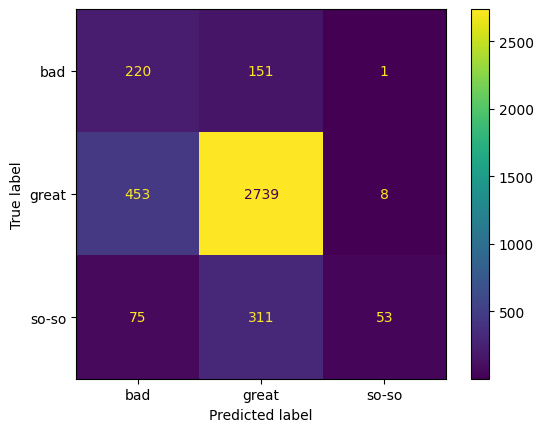

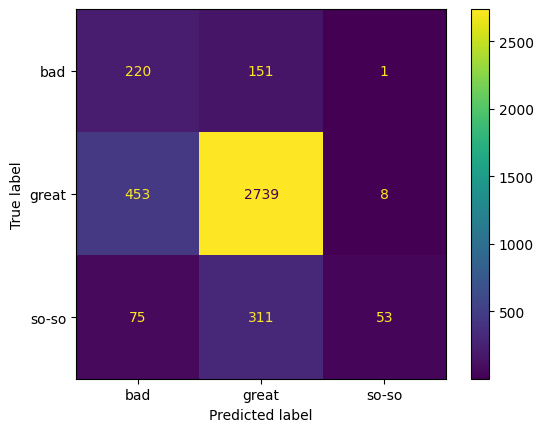

In [ ]:
ConfusionMatrixDisplay.from_estimator(voting, X_test, y_test_class).plot()

In [ ]:
### BaggingClassifier

class_weights = {0: 10, 1: 20, 2: 1}
base_estimators = {
    'tree': DecisionTreeClassifier(
        random_state=21,
        class_weight=class_weights,
        max_depth=10,
        max_features='sqrt'
    ),
    'forest': RandomForestClassifier(
        random_state=21,
        class_weight=class_weights,
        max_depth=10,
        n_estimators=50
    ),
    'sgd': SGDClassifier(
        loss='hinge',
        class_weight=class_weights,
        max_iter=1000,
        random_state=21
    )
}

param_combinations = [
    {'n_estimators': 100, 'max_samples': 0.7, 'max_features': 0.7},
    {'n_estimators': 200, 'max_samples': 1.0, 'max_features': 1.0}
]

results = []

total_iterations = len(base_estimators) * len(param_combinations)

with tqdm(total=total_iterations, desc="Bagging combinations") as pbar:
    for model_name, base_estimator in base_estimators.items():
        for params in param_combinations:
            bagging = BaggingClassifier(
                estimator=base_estimator,
                random_state=21,
                **params
            )

            bagging.fit(X_train, y_train_class)
            y_valid_pred = bagging.predict(X_valid)

            precision = precision_score(y_valid_class, y_valid_pred, average='weighted')
            accuracy = accuracy_score(y_valid_class, y_valid_pred)
            recall = recall_score(y_valid_class, y_valid_pred, average='weighted')

            results.append({
                'model': model_name,
                'params': params,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall
            })

            pbar.update(1)

sorted_results = sorted(results, key=lambda x: (x['precision'], x['accuracy']), reverse=True)
best_config = sorted_results[0]

Bagging combinations:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Bagging combinations:  17%|█▋        | 1/6 [00:03<00:15,  3.11s/it]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Bagging combinations:  33%|███▎      | 2/6 [00:08<00:17,  4.34s/it]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pred

In [ ]:
best_model = BaggingClassifier(
    estimator=base_estimators[best_config['model']],
    random_state=21,
    **best_config['params']
)

best_model.fit(X_train_full, y_train_full_class)
y_pred = best_model.predict(X_test)

print(f"accuracy is {accuracy_score(y_test_class, y_pred):.5f}")
print(f"precision is {precision_score(y_test_class, y_pred, average='weighted'):.5f}")
print(f"recall is {recall_score(y_test_class, y_pred, average='weighted'):.5f}")

accuracy is 0.79855
precision is 0.69533
recall is 0.79855


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


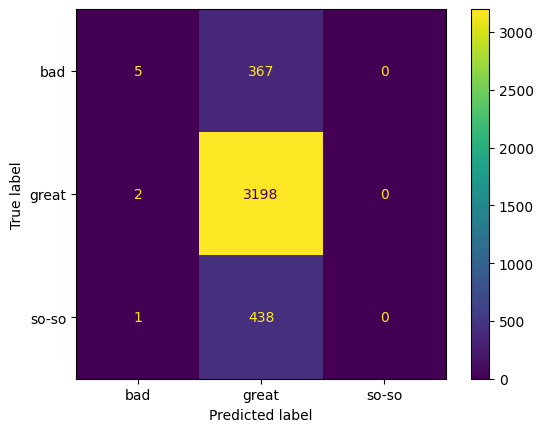

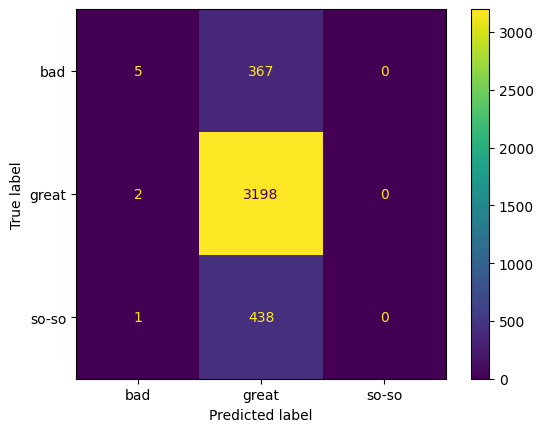

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test_class).plot()

In [ ]:
### BalancedRandomForestClassifier

n_estimators_list = [200, 400, 500]
max_depth_list = [20, 30, 50]
min_samples_leaf_list = [1, 5, 10]
max_features_list = ['sqrt', 0.7]
replacement_options = [True, False]

results = []
param_combinations = list(product(n_estimators_list, max_depth_list, min_samples_leaf_list, max_features_list, replacement_options))

for i, (n_estimators, max_depth, min_samples_leaf, max_features, replacement) in enumerate(tqdm(param_combinations, total=len(param_combinations), desc="Balanced Random Forest tuning")):

    model = BalancedRandomForestClassifier(
        random_state=21,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        sampling_strategy='auto',
        replacement=replacement
    )

    model.fit(X_train, y_train_class)
    y_valid_pred = model.predict(X_valid)

    precision = precision_score(y_valid_class, y_valid_pred, average='weighted')
    accuracy = accuracy_score(y_valid_class, y_valid_pred)
    recall = recall_score(y_valid_class, y_valid_pred, average='weighted')

    results.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features,
        'replacement': replacement,
        'precision': precision,
        'accuracy': accuracy,
        'recall': recall
    })

sorted_results = sorted(results, key=lambda x: (x['precision'], x['accuracy']), reverse=True)

Balanced Random Forest tuning: 100%|██████████| 108/108 [44:12<00:00, 24.56s/it]


In [ ]:
balanced = BalancedRandomForestClassifier(
    random_state=21,
    n_estimators=200,
    max_depth=50,
    min_samples_leaf=1,
    max_features='sqrt',
    sampling_strategy='auto',
    replacement=True
)

balanced.fit(X_train_full, y_train_full_class)
y_pred = balanced.predict(X_test)

print(f"accuracy is {accuracy_score(y_test_class, y_pred):.5f}")
print(f"precision is {precision_score(y_test_class, y_pred, average='weighted'):.5f}")
print(f"recall is {recall_score(y_test_class, y_pred, average='weighted'):.5f}")

accuracy is 0.63700
precision is 0.74811
recall is 0.63700


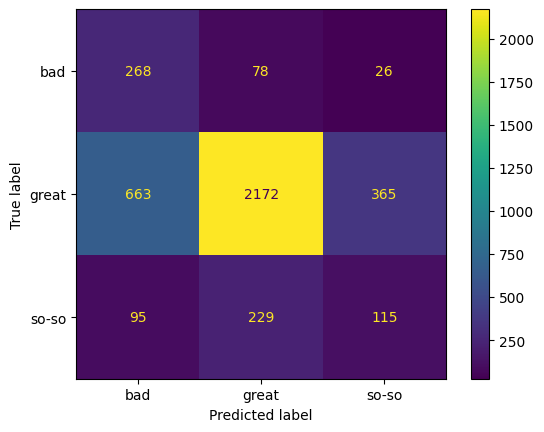

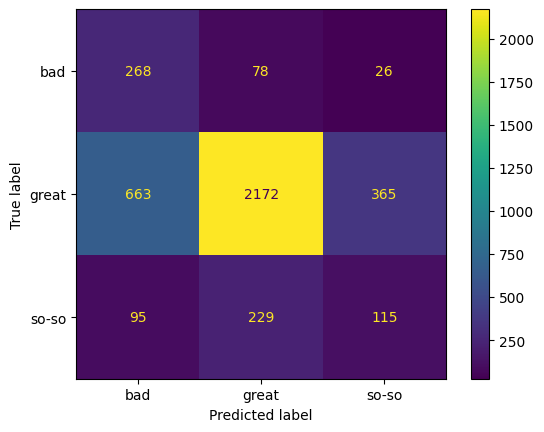

In [ ]:
ConfusionMatrixDisplay.from_estimator(balanced, X_test, y_test_class).plot()

In [ ]:
balanced = BalancedRandomForestClassifier(
    random_state=21,
    n_estimators=400,
    max_depth=50,
    min_samples_leaf=1,
    max_features='sqrt',
    sampling_strategy='auto',
    replacement=True
)

balanced.fit(X_train_full, y_train_full_class)
y_pred = balanced.predict(X_test)

print(f"accuracy is {accuracy_score(y_test_class, y_pred):.5f}")
print(f"precision is {precision_score(y_test_class, y_pred, average='weighted'):.5f}")
print(f"recall is {recall_score(y_test_class, y_pred, average='weighted'):.5f}")

accuracy is 0.63276
precision is 0.74779
recall is 0.63276


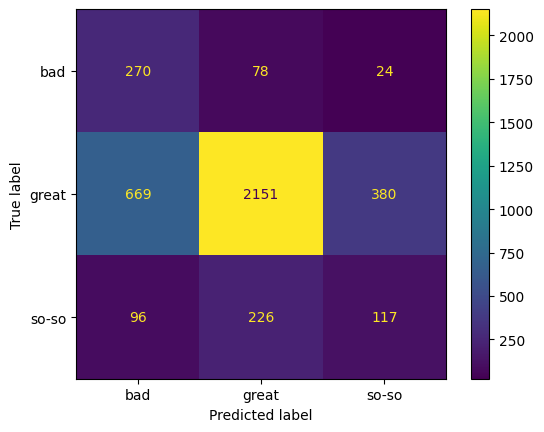

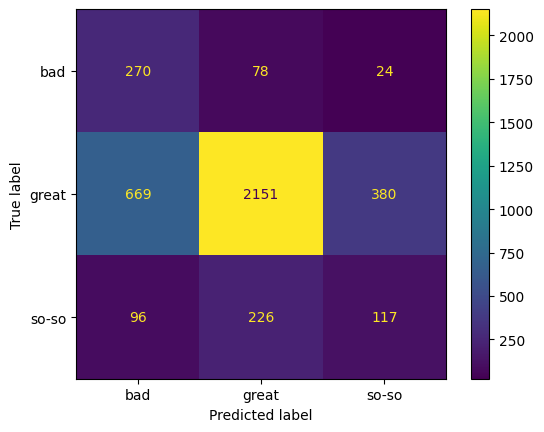

In [ ]:
ConfusionMatrixDisplay.from_estimator(balanced, X_test, y_test_class).plot()

### Decision

- Decide what is better to use: the regression model or the
classification.
Save the best model. You will use it in the program.

In [ ]:
final_model = BalancedRandomForestClassifier(
    random_state=21,
    n_estimators=200,
    max_depth=50,
    min_samples_leaf=1,
    max_features='sqrt',
    sampling_strategy='auto',
    replacement=True
)

data_y = data_y.round().astype(int)
data_y = data_y.map(lambda x: 'bad' if x in (0, 1) else 'so-so' if x in (2, 3) else 'great')
final_model.fit(data_X, data_y)
joblib.dump(final_model, '../data/best_model.pkl')
data_X.to_csv('../data/features.csv', index=False)

In [ ]:
data_X.to_csv('../data/features.csv', index=False)

# Nutrition Facts

##### Collect all the nutrition facts for the ingredients from your prepared and filtered dataset (only ingredient columns) into a dataframe. Use the following API for that.

In [ ]:
#### ---------- API KEY ---------- ####
API_KEY = ''
URL = 'https://api.nal.usda.gov/fdc/v1/foods/search'

ingredients = pd.read_csv('../data/features.csv').columns.tolist()

nutrient_data = []
for ing in tqdm(ingredients):
    params = {
        'api_key': API_KEY,
        'query': ing,
        'pageSize': 1
    }
    response = requests.get(url=URL, params=params)
    data = response.json()

    row = {}
    if data.get('foods'):
        food = data['foods'][0]
        for n in food.get('foodNutrients', []):
            row[n['nutrientName']] = n.get('value', None)

    nutrient_data.append(pd.Series(row, name=ing))

df_nutrition = pd.DataFrame(nutrient_data)
df_nutrition.index.name = 'ingredient'
df_nutrition.head()

100%|██████████| 406/406 [01:21<00:00,  5.00it/s]


,Protein,Total lipid (fat),"Carbohydrate, by difference",Energy,"Alcohol, ethyl",Water,Caffeine,Theobromine,Total Sugars,"Fiber, total dietary",...,PUFA 20:3 n-3,PUFA 18:3i,Energy (Atwater General Factors),Energy (Atwater Specific Factors),Stigmasterol,SFA 13:0,Beta-sitosterol,Campesterol,"Fiber, soluble",PUFA 18:2 i
ingredient,,,,,,,,,,,,,,,,,,,,,
almond,20.67,52.72,21.11,641.0,0.0,1.74,0.0,0.0,4.40,9.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amaretto,0.00,10.00,33.30,233.0,NaN,NaN,NaN,NaN,33.30,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
anchovy,28.89,9.71,0.00,210.0,0.0,50.30,0.0,0.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
anise,17.60,15.90,50.00,1410.0,0.0,9.54,0.0,0.0,NaN,14.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aperitif,0.00,0.00,9.09,34.0,NaN,NaN,NaN,NaN,4.55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_nutrition.columns = [re.split(r'[,(]', col)[0].strip() for col in df_nutrition.columns]
sfa_columns = [col for col in df_nutrition.columns if re.fullmatch(r'SFA \d{2}:\d', str(col))]
df_nutrition['Saturated fat'] = df_nutrition[sfa_columns].sum(axis=1)
df_nutrition = df_nutrition.rename(columns={'Sugars':'Added sugars'})
print(df_nutrition.columns.tolist())

['Protein', 'Total lipid', 'Carbohydrate', 'Energy', 'Alcohol', 'Water', 'Caffeine', 'Theobromine', 'Total Sugars', 'Fiber', 'Calcium', 'Iron', 'Magnesium', 'Phosphorus', 'Potassium', 'Sodium', 'Zinc', 'Copper', 'Selenium', 'Retinol', 'Vitamin A', 'Carotene', 'Carotene', 'Vitamin E', 'Vitamin D', 'Cryptoxanthin', 'Lycopene', 'Lutein + zeaxanthin', 'Vitamin C', 'Thiamin', 'Riboflavin', 'Niacin', 'Vitamin B-6', 'Folate', 'Vitamin B-12', 'Choline', 'Vitamin K', 'Folic acid', 'Folate', 'Folate', 'Vitamin E', 'Vitamin B-12', 'Cholesterol', 'Fatty acids', 'SFA 4:0', 'SFA 6:0', 'SFA 8:0', 'SFA 10:0', 'SFA 12:0', 'SFA 14:0', 'SFA 16:0', 'SFA 18:0', 'MUFA 18:1', 'PUFA 18:2', 'PUFA 18:3', 'PUFA 20:4', 'PUFA 22:6 n-3', 'MUFA 16:1', 'PUFA 18:4', 'MUFA 20:1', 'PUFA 20:5 n-3', 'MUFA 22:1', 'PUFA 22:5 n-3', 'Fatty acids', 'Fatty acids', 'Vitamin D', 'Added sugars', 'Fatty acids', 'Pantothenic acid', 'Ash', 'Manganese', 'Vitamin A', 'Vitamin A', 'Vitamin D3', 'Vitamin E', 'Isoleucine', 'Leucine', 'Lys

##### Transform all the values into % of the daily value. Keep only nutrients that exist in this and that table.

In [ ]:
daily_values = {
    'Fat': 78,
    'Saturated fat': 20,
    'Cholesterol': 300,
    'Carbohydrate': 275,
    'Sodium': 2300,
    'Fiber': 28,
    'Protein': 50,
    'Added sugars': 50,
    'Vitamin A': 900,
    'Vitamin C': 90,
    'Calcium': 1300,
    'Iron': 18,
    'Vitamin D': 20,
    'Vitamin E': 15,
    'Vitamin K': 120,
    'Thiamin': 1.2,
    'Riboflavin': 1.3,
    'Niacin': 16,
    'Vitamin B-6': 1.7,
    'Folate': 400,
    'Vitamin B-12': 2.4,
    'Biotin': 30,
    'Pantothenic acid': 5,
    'Phosphorus': 1250,
    'Iodine': 150,
    'Magnesium': 420,
    'Zinc': 11,
    'Selenium': 55,
    'Copper': 0.9,
    'Manganese': 2.3,
    'Chromium': 35,
    'Molybdenum': 45,
    'Chloride': 2300,
    'Potassium': 4700,
    'Choline':550
}

In [ ]:
df_nutr = df_nutrition[[col for col in df_nutrition.columns if col in daily_values.keys()]]
df_nutr_clean = (
    df_nutr.T
    .groupby(df_nutr.columns)
    .agg(lambda x: x.fillna(0).max())
    .T
)
df_nutr_clean.head()

,Added sugars,Calcium,Carbohydrate,Cholesterol,Choline,Copper,Fiber,Folate,Iron,Magnesium,...,Sodium,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Vitamin D,Vitamin E,Vitamin K,Zinc
ingredient,,,,,,,,,,,,,,,,,,,,,
almond,0.0,263.0,21.11,0.0,51.8,0.969,9.6,42.0,4.08,266.0,...,232.0,0.094,0.0,0.00,0.083,0.0,0.0,16.57,0.0,3.16
amaretto,33.3,0.0,33.30,0.0,0.0,0.000,0.0,0.0,0.00,0.0,...,67.0,0.000,0.0,0.00,0.000,0.0,0.0,0.00,0.0,0.00
anchovy,0.0,232.0,0.00,85.0,85.0,0.339,0.0,13.0,4.63,69.0,...,3668.0,0.078,12.0,0.88,0.203,0.0,1.7,3.33,12.1,2.44
anise,0.0,646.0,50.00,0.0,0.0,0.910,14.6,10.0,37.00,170.0,...,16.0,0.340,311.0,0.00,0.650,21.0,0.0,0.00,0.0,5.30
aperitif,0.0,0.0,9.09,0.0,0.0,0.000,0.0,0.0,0.00,0.0,...,0.0,0.000,0.0,0.00,0.000,0.0,0.0,0.00,0.0,0.00


In [ ]:
nutrients_daily = df_nutr_clean.copy()

for nutrient, dv in daily_values.items():
    if nutrient in nutrients_daily:
        nutrients_daily[nutrient] = (nutrients_daily[nutrient] / dv) * 100
        nutrients_daily[nutrient] = round(nutrients_daily[nutrient]).astype(int)

nutrients_daily.head()

,Added sugars,Calcium,Carbohydrate,Cholesterol,Choline,Copper,Fiber,Folate,Iron,Magnesium,...,Sodium,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Vitamin D,Vitamin E,Vitamin K,Zinc
ingredient,,,,,,,,,,,,,,,,,,,,,
almond,0,20,8,0,9,108,34,10,23,63,...,10,8,0,0,5,0,0,110,0,29
amaretto,67,0,12,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
anchovy,0,18,0,28,15,38,0,3,26,16,...,159,6,1,37,12,0,8,22,10,22
anise,0,50,18,0,0,101,52,2,206,40,...,1,28,35,0,38,23,0,0,0,48
aperitif,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Save the transformed dataframe into a CSV file that you will use in your main

In [ ]:
nutrients_daily.to_csv('../data/nutrients.csv')

# Similar Recipes

##### For each recipe from the dataset, collect the URL from epicurious.com with its details (if there is no URL for that recipe, skip it).

In [89]:
URL = 'https://www.epicurious.com/'
data = pd.read_csv('../data/epi_r.csv')
titles = data[['title', 'rating']]

def build__url(title):
    base_url = "https://www.epicurious.com/search?q="
    query = title.strip().replace(" ", "+")
    search_url = base_url + query
    return search_url

urls_df = []

for _, row in tqdm(titles.iterrows(), total=len(titles)):
    title = row['title']
    rating = round(row['rating'], 1) if pd.notnull(row['rating']) else None
    link = build__url(title)

    if link:
        urls_df.append({
            'title': title,
            'rating': rating,
            'url': link
        })

100%|██████████| 5326/5326 [00:00<00:00, 5880.42it/s]


##### Save the new dataframe to a CSV file that you will use in your main program.

In [90]:
result = pd.DataFrame(urls_df)
result.to_csv('data/urls_recipes.csv')